In [1]:
from Medfl.LearningManager.utils import global_params

import sys
sys.path.append(global_params['base_url'])

import os
os.environ['PYTHONPATH'] = global_params['base_url']

In [2]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine,text
import subprocess


# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


## MedFL Imports 
## Network Manager Imports 
from Medfl.NetManager.node import Node
from Medfl.NetManager.network import Network
from Medfl.NetManager.dataset import DataSet
from Medfl.NetManager.flsetup import FLsetup

# flower imports 
import flwr as fl

## Learning Manager imports 
from Medfl.LearningManager.dynamicModal import DynamicModel
from Medfl.LearningManager.model import Model
from Medfl.LearningManager.strategy import Strategy
from Medfl.LearningManager.server import *
from Medfl.LearningManager.flpipeline import *
from Medfl.LearningManager.plot import AccuracyLossPlotter



# Utils
from Medfl.LearningManager.utils import *


2024-03-25 15:54:03.195433: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, num_layers, layer_size):
        super(BinaryClassifier, self).__init__()

        # Input layer
        self.layers = [nn.Linear(input_size, layer_size)]
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(layer_size, layer_size))
        
        # Output layer
        self.layers.append(nn.Linear(layer_size, 1))
        
        # ModuleList to handle dynamic number of layers
        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [4]:
# Best HyperParams using optuna optimisation 
best_hyperparams = {'batch_size': 16, 'num_layers': 6, 'hidden_size': 46,
                    'optimizer': 'RMSprop', 'learning_rate': 0.0019940796634093597, 'num_epochs': 1}

In [5]:
#  Best threshold
best_th = 0.3

In [6]:
# The number of server rounds
n_rounds = [2 , 3]

In [7]:
benchmarks_config = {
    # * 1 . Differential Privacy
    # *******************************************
    "diff_privacy": [
        {
            # DP config
            "dp_activate": False,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "Train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # DP config
            "dp_activate": True,
            "DELTA": 1e-5,
            "EPSILON": 5.0,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "Train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # DP config
            "dp_activate": True,
            "DELTA": 1e-5,
            "EPSILON": 10.0,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "Train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # DP config
            "dp_activate": True,
            "DELTA": 1e-5,
            "EPSILON": 0.5,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "Train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # DP config
            "dp_activate": True,
            "DELTA": 1e-10,
            "EPSILON": 0.5,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "Train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        }
    ],
    # * 2 . Nodes Config
    # *******************************************
    "nodes_config": [
        {
            # nodes config
            "train_test": True,
            "train_portion": 0.5,

            # The rest of the config
            "n_clients": 10,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # nodes config
            "train_test": True,
            "train_portion": 0.7,

            # The rest of the config
            "n_clients": 10,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # nodes config
            "train_test": False,
            "train_portion": 0.5,

            # The rest of the config
            "n_clients": 10,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
        {
            # nodes config
            "train_test": False,
            "train_portion": 0.7,

            # The rest of the config
            "n_clients": 10,
            "dp_activate": False,
            "aggreg_algo": "FedAvg",
            "Tl": True,
        },
    ],
    # * 3 . Aggregation Algorithm
    # *******************************************
    "Aggreg_algo": [
        {
            # Aggregation alrogithm
            "aggreg_algo": "FedAvg",

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "n_clients": 10,
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Aggregation alrogithm
            "aggreg_algo": "FedYogy",

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "n_clients": 10,
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Aggregation alrogithm
            "aggreg_algo": "FedAdaGrad",

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "n_clients": 10,
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Aggregation alro100githm
            "aggreg_algo": "FedAdam",

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "n_clients": 10,
            "dp_activate": False,
            "Tl": True,
        },
    ],
    # * 4 . Aggregation Algorithm
    # *******************************************
    "n_clients": [
        {
            # Number of clients
            "n_clients": 5,

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Number of clients
            "n_clients": 10,

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "dp_activate": False,
            "Tl": True,
        },
        {
            # Number of clients
            "n_clients": 30,

            # The rest of the config
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "dp_activate": False,
            "Tl": True,
        },

    ],
    # * 5 . Combine the configurations 
    # *******************************************
    "combined_config": [{
     
    }]
}

In [8]:
benchmarks_config = {
    "diff_privacy" : [
          {
            # DP config
            "dp_activate": False,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedYogi",
            "Tl": False,
        },
     {
            # DP config
            "dp_activate": False,

            # The rest of the config
            "n_clients": 10,
            "train_test": True,
            "train_portion": 0.5,
            "aggreg_algo": "FedAvg",
            "Tl": False,
        } 
    ]
}

In [9]:
# Benchmarks_result stors the result of each configuration in the benchmark 
benchmarks_results = []

In [10]:
# a fuction to test if the config is already tested
def is_config_tested(config , n_rounds):
    for result in benchmarks_results:
        if result['config'] == config and n_rounds == result['n_rounds'] : return True
    
    return False 

In [11]:
device = torch.device(
            f"cuda" if torch.cuda.is_available() else "cpu"
        )

In [12]:

# Loop Over the benchmark configs
for key in benchmarks_config.keys():
    print("Executing the: " + key + " configurations")
    for config in benchmarks_config[key]:
        print("Executing th confuguration")
        print(config)
        for server_rounds in n_rounds:
            if(is_config_tested(config=config , n_rounds=server_rounds)):
                break
            # Create the MEDfl pipeline for each config

            # DB Creation
            subprocess.run(['python3', '../../scripts/create_db.py'])

            # Create a nest work "Net_1"
            Net_1 = Network(name="manual_network_2")
            Net_1.create_network()

            # Create a MasterDataSet from Net_1
            Net_1.create_master_dataset()

            # auto FLsetup creation
            autoFl = FLsetup(name="Flsetup_2",
                             description="The second fl setup", network=Net_1)
            autoFl.create()

            # Create Nodes
            if (config['train_test']):
                n_train = int(config['n_clients']*config['train_portion'])

                #  Create the Train nodes
                for i in range(1, 1 + n_train):
                    hospital = Node(name="hospital_"+str(i), train=1)
                    Net_1.add_node(hospital)
                    hospital.upload_dataset(
                        "hospital_"+str(i)+'_dataset', global_params['base_url'] + '/notebooks/data/nodesData/output_'+str(i)+'.csv')

                #  Create the test nodes
                for i in range(1 + n_train, config['n_clients'] + 1):
                    hospital = Node(name="hospital_"+str(40+i), train=0)
                    Net_1.add_node(hospital)
                    hospital.upload_dataset("hospital_"+str(40+i)+'_dataset',
                                            global_params['base_url'] + '/notebooks/data/nodesData/output_'+str(i)+'.csv')

                #  Create a test+train nodes
                else:
                    pass

            # Create FLDataSet
            fl_dataset = autoFl.create_federated_dataset(
                output="deceased",
                fit_encode=[],
                to_drop=["deceased"]
            )

            if (config['Tl']):
                # Load the pretrained model
                model = Model.load_model(
                    "../../notebooks/.ipynb_checkpoints/trainedModels/grid_search_classifier.pth")
            else:
                # Create the model with the suggested hyperparameters
                model = BinaryClassifier(input_size=fl_dataset.size,
                                         num_layers=best_hyperparams['num_layers'],
                                         layer_size=best_hyperparams['hidden_size'],)
                model.to(device)

            # Pass the specific_model to the Model class
            if best_hyperparams['optimizer'] == 'Adam':
                optimizer = optim.Adam(
                    model.parameters(), lr=best_hyperparams['learning_rate'])
            elif best_hyperparams['optimizer'] == 'SGD':
                optimizer = optim.SGD(model.parameters(),
                                      lr=best_hyperparams['learning_rate'])
            elif best_hyperparams['optimizer'] == 'RMSprop':
                optimizer = optim.RMSprop(
                    model.parameters(), lr=best_hyperparams['learning_rate'])

            # Define loss function and optimizer

            pos_weight = torch.tensor([(1 - best_th) / best_th])
            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

            # Creating a new Model instance using the specific model created by DynamicModel
            global_model = Model(model, optimizer, criterion)

            # Get the initial params of the model
            init_params = global_model.get_parameters()

            # Create the strategy
            aggreg_algo = Strategy(config['aggreg_algo'],
                                   fraction_fit=1.0,
                                   fraction_evaluate=1.0,
                                   min_fit_clients=2,
                                   min_evaluate_clients=2,
                                   min_available_clients=2,
                                   initial_parameters=global_model.get_parameters())
            aggreg_algo.create_strategy()

            # Create The server
            server = FlowerServer(global_model,
                                  strategy=aggreg_algo,
                                  num_rounds=server_rounds,
                                  num_clients=len(fl_dataset.trainloaders),
                                  fed_dataset=fl_dataset,
                                  diff_privacy=config['dp_activate'],
                                  # You can change the resources alocated for each client based on your machine
                                  client_resources={
                                      'num_cpus': 1.0, 'num_gpus': 1.0}
                                  )
            # Create the pipeline
            ppl_1 = FLpipeline(name="the second fl_pipeline",
                               description="this is our first FL pipeline",
                               server=server)
            
            # Run the Traning of the model
            history = ppl_1.server.run()
            
            # store the results 
            benchmarks_results.append({
                'n_rounds' : server_rounds,
                'config' : config , 
                'results' : server.auc[len(server.auc)-1]
            })


Executing the: diff_privacy configurations
Executing th confuguration
{'dp_activate': False, 'n_clients': 10, 'train_test': True, 'train_portion': 0.5, 'aggreg_algo': 'FedYogi', 'Tl': False}


/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/pandas/io/sql.py:1761: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  return insp.has_table(name, schema or self.meta.schema)


/home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/notebooks/data/masterDataSet/Mimic_ouael.csv


INFO flwr 2024-03-25 15:54:58,699 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
03/25/2024 15:54:58:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
2024-03-25 15:55:01,248	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-25 15:55:03,680 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 38158905754.0, 'node:__internal_head__': 1.0, 'CPU': 24.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0}
03/25/2024 15:55:03:INFO:Flower VCE: Ray initialized with resources: {'memory': 38158905754.0, 'node:__internal_head__': 1.0, 'CPU': 24.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0}
INFO flwr 2024-03-25 15:55:03,681 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/25/2024 15:55:03:INFO:Optim

/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0


(DefaultActor pid=1294302) /home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/Medfl/LearningManager/utils.py:19: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
(DefaultActor pid=1294302)   global_yaml_path = pkg_resources.resource_filename(__name__, "../../global_params.yaml")


(DefaultActor pid=1294302) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1294302) i m here
(DefaultActor pid=1294302) the model is runing on CUDA
(DefaultActor pid=1294302) 
(DefaultActor pid=1294302)  -------------------------------- 
(DefaultActor pid=1294302)   this is the config of the client
(DefaultActor pid=1294302) [Client 3] fit, config: {}
(DefaultActor pid=1294302) 
(DefaultActor pid=1294302)  -------------------------------- 
(DefaultActor pid=1294302)   


(DefaultActor pid=1294302) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1294302)   warnings.warn(
(DefaultActor pid=1294302) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1294302)   client = check_clientfn_returns_client(client_fn(cid))


(DefaultActor pid=1294302) 	Train Epoch: 0 	Loss: 1.182699 Acc@1: 2.500000
(DefaultActor pid=1294302) 	Train Epoch: 0 	Loss: 0.960182 Acc@1: 1.250000
(DefaultActor pid=1294302) 	Train Epoch: 1 	Loss: 0.766519 Acc@1: 2.500000
(DefaultActor pid=1294302) 	Train Epoch: 1 	Loss: 0.738490 Acc@1: 1.250000
(DefaultActor pid=1294302) 	Train Epoch: 2 	Loss: 0.761339 Acc@1: 2.500000
(DefaultActor pid=1294302) 	Train Epoch: 2 	Loss: 0.730279 Acc@1: 1.250000
(DefaultActor pid=1294302) 	Train Epoch: 3 	Loss: 0.752457 Acc@1: 2.500000
(DefaultActor pid=1294302) 	Train Epoch: 3 	Loss: 0.722478 Acc@1: 1.250000
(DefaultActor pid=1294302) 	Train Epoch: 4 	Loss: 0.750442 Acc@1: 2.500000
(DefaultActor pid=1294302) 	Train Epoch: 4 	Loss: 0.724182 Acc@1: 1.250000
(DefaultActor pid=1294302) 	Train Epoch: 5 	Loss: 0.744460 Acc@1: 2.500000
(DefaultActor pid=1294302) 	Train Epoch: 5 	Loss: 0.716577 Acc@1: 1.250000
(DefaultActor pid=1294302) 	Train Epoch: 6 	Loss: 0.742342 Acc@1: 2.500000
(DefaultActor pid=1294302

DEBUG flwr 2024-03-25 15:55:48,469 | server.py:236 | fit_round 1 received 5 results and 0 failures
03/25/2024 15:55:48:DEBUG:fit_round 1 received 5 results and 0 failures
WARNING flwr 2024-03-25 15:55:48,492 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
03/25/2024 15:55:48:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-03-25 15:55:48,509 | server.py:125 | fit progress: (1, 0.033037466745750574, {'accuracy': 0.8255208333333334}, 44.791763867018744)
03/25/2024 15:55:48:INFO:fit progress: (1, 0.033037466745750574, {'accuracy': 0.8255208333333334}, 44.791763867018744)
DEBUG flwr 2024-03-25 15:55:48,510 | server.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 5)
03/25/2024 15:55:48:DEBUG:evaluate_round 1: strategy sampled 5 clients (out of 5)


(DefaultActor pid=1294302) 	Train Epoch: 112 	Loss: 0.695316 Acc@1: 5.000000
(DefaultActor pid=1294302) 	Train Epoch: 113 	Loss: 0.703457 Acc@1: 2.187500
(DefaultActor pid=1294302) 	Train Epoch: 113 	Loss: 0.658838 Acc@1: 9.218750
(DefaultActor pid=1294302) 	Train Epoch: 114 	Loss: 0.707943 Acc@1: 2.187500
(DefaultActor pid=1294302) 	Train Epoch: 114 	Loss: 0.664474 Acc@1: 9.218750
(DefaultActor pid=1294302) 	Train Epoch: 115 	Loss: 0.694130 Acc@1: 2.187500
(DefaultActor pid=1294302) 	Train Epoch: 115 	Loss: 0.653173 Acc@1: 9.218750
(DefaultActor pid=1294302) epsilon of client 0 : eps = 0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0


(DefaultActor pid=1294302) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1294302)   warnings.warn(
(DefaultActor pid=1294302) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1294302)   client = check_clientfn_returns_client(client_fn(cid))
(DefaultActor pid=1294302) /home/local/USHERBROOKE/s

(DefaultActor pid=1294302) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1294302) i m here
(DefaultActor pid=1294302) the model is runing on CUDA
(DefaultActor pid=1294302) [Client 0] evaluate, config: {}
(DefaultActor pid=1294302) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) ///////////////////////////////

DEBUG flwr 2024-03-25 15:56:26,904 | server.py:236 | fit_round 2 received 5 results and 0 failures
03/25/2024 15:56:26:DEBUG:fit_round 2 received 5 results and 0 failures
INFO flwr 2024-03-25 15:56:26,934 | server.py:125 | fit progress: (2, 0.032681476251751766, {'accuracy': 0.8177083333333334}, 83.21658422402106)
03/25/2024 15:56:26:INFO:fit progress: (2, 0.032681476251751766, {'accuracy': 0.8177083333333334}, 83.21658422402106)
DEBUG flwr 2024-03-25 15:56:26,935 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 5)
03/25/2024 15:56:26:DEBUG:evaluate_round 2: strategy sampled 5 clients (out of 5)


(DefaultActor pid=1294302) 	Train Epoch: 113 	Loss: 0.782044 Acc@1: 2.187500
(DefaultActor pid=1294302) 	Train Epoch: 113 	Loss: 0.731425 Acc@1: 5.000000
(DefaultActor pid=1294302) 	Train Epoch: 114 	Loss: 0.735973 Acc@1: 2.187500
(DefaultActor pid=1294302) 	Train Epoch: 114 	Loss: 0.699759 Acc@1: 9.218750
(DefaultActor pid=1294302) 	Train Epoch: 115 	Loss: 0.736563 Acc@1: 2.187500
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0


(DefaultActor pid=1294302) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1294302)   warnings.warn(
(DefaultActor pid=1294302) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1294302)   client = check_clientfn_returns_client(client_fn(cid))
(DefaultActor pid=1294302) /home/local/USHERBROOKE/s

(DefaultActor pid=1294302) 	Train Epoch: 115 	Loss: 0.709336 Acc@1: 1.093750
(DefaultActor pid=1294302) epsilon of client 0 : eps = 0
(DefaultActor pid=1294302) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1294302) i m here
(DefaultActor pid=1294302) the model is runing on CUDA
(DefaultActor pid=1294302) [Client 2] evaluate, config: {}
(DefaultActor pid=1294302) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) //////////////////////////////////////////////////////////////

(DefaultActor pid=1294302) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1294302)   warnings.warn(
(DefaultActor pid=1294302) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1294302)   client = check_clientfn_returns_client(client_fn(cid))


(DefaultActor pid=1294302) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1294302) i m here
(DefaultActor pid=1294302) the model is runing on CUDA
(DefaultActor pid=1294302) [Client 0] evaluate, config: {}
(DefaultActor pid=1294302) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1294302) cuda:0
(DefaultActor pid=1294302) cuda:0
/home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/notebook

INFO flwr 2024-03-25 15:57:16,370 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
03/25/2024 15:57:16:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2024-03-25 15:57:20,533	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-25 15:57:22,911 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 38174561895.0, 'CPU': 24.0, 'node:__internal_head__': 1.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'accelerator_type:G': 1.0, 'GPU': 1.0}
03/25/2024 15:57:22:INFO:Flower VCE: Ray initialized with resources: {'memory': 38174561895.0, 'CPU': 24.0, 'node:__internal_head__': 1.0, 'node:10.44.86.57': 1.0, 'object_store_memory': 78643200.0, 'accelerator_type:G': 1.0, 'GPU': 1.0}
INFO flwr 2024-03-25 15:57:22,912 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/25/2024 15:57:22:INFO:Optim

/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0


(DefaultActor pid=1295135) /home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/Medfl/LearningManager/utils.py:19: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
(DefaultActor pid=1295135)   global_yaml_path = pkg_resources.resource_filename(__name__, "../../global_params.yaml")


(DefaultActor pid=1295135) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) i m here


(DefaultActor pid=1295135) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1295135)   warnings.warn(
(DefaultActor pid=1295135) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1295135)   client = check_clientfn_returns_client(client_fn(cid))


(DefaultActor pid=1295135) the model is runing on CUDA
(DefaultActor pid=1295135) 
(DefaultActor pid=1295135)  -------------------------------- 
(DefaultActor pid=1295135)   this is the config of the client
(DefaultActor pid=1295135) [Client 0] fit, config: {}
(DefaultActor pid=1295135) 
(DefaultActor pid=1295135)  -------------------------------- 
(DefaultActor pid=1295135)   
(DefaultActor pid=1295135) 	Train Epoch: 0 	Loss: 1.676721 Acc@1: 7.187500
(DefaultActor pid=1295135) 	Train Epoch: 0 	Loss: 1.292290 Acc@1: 3.593750
(DefaultActor pid=1295135) 	Train Epoch: 1 	Loss: 0.894627 Acc@1: 2.187500
(DefaultActor pid=1295135) 	Train Epoch: 1 	Loss: 0.855032 Acc@1: 1.093750
(DefaultActor pid=1295135) 	Train Epoch: 2 	Loss: 0.880047 Acc@1: 0.000000
(DefaultActor pid=1295135) 	Train Epoch: 2 	Loss: 0.846204 Acc@1: 0.625000
(DefaultActor pid=1295135) 	Train Epoch: 3 	Loss: 0.872376 Acc@1: 0.000000
(DefaultActor pid=1295135) 	Train Epoch: 3 	Loss: 0.840637 Acc@1: 0.625000
(DefaultActor pid=1

DEBUG flwr 2024-03-25 15:58:12,956 | server.py:236 | fit_round 1 received 5 results and 0 failures
03/25/2024 15:58:12:DEBUG:fit_round 1 received 5 results and 0 failures
WARNING flwr 2024-03-25 15:58:12,965 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
03/25/2024 15:58:12:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-03-25 15:58:12,979 | server.py:125 | fit progress: (1, 0.03320106863975525, {'accuracy': 0.7838541666666666}, 50.04615653282963)
03/25/2024 15:58:12:INFO:fit progress: (1, 0.03320106863975525, {'accuracy': 0.7838541666666666}, 50.04615653282963)
DEBUG flwr 2024-03-25 15:58:12,980 | server.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 5)
03/25/2024 15:58:12:DEBUG:evaluate_round 1: strategy sampled 5 clients (out of 5)


(DefaultActor pid=1295135) 	Train Epoch: 112 	Loss: 0.611685 Acc@1: 1.093750
(DefaultActor pid=1295135) 	Train Epoch: 113 	Loss: 0.537128 Acc@1: 0.312500
(DefaultActor pid=1295135) 	Train Epoch: 113 	Loss: 0.599893 Acc@1: 1.093750
(DefaultActor pid=1295135) 	Train Epoch: 114 	Loss: 0.519005 Acc@1: 0.000000
(DefaultActor pid=1295135) 	Train Epoch: 114 	Loss: 0.591429 Acc@1: 0.937500
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0


(DefaultActor pid=1295135) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1295135)   warnings.warn(
(DefaultActor pid=1295135) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1295135)   client = check_clientfn_returns_client(client_fn(cid))
(DefaultActor pid=1295135) /home/local/USHERBROOKE/s

(DefaultActor pid=1295135) 	Train Epoch: 115 	Loss: 0.528223 Acc@1: 0.312500
(DefaultActor pid=1295135) 	Train Epoch: 115 	Loss: 0.586631 Acc@1: 1.093750
(DefaultActor pid=1295135) epsilon of client 3 : eps = 0
(DefaultActor pid=1295135) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) i m here
(DefaultActor pid=1295135) the model is runing on CUDA
(DefaultActor pid=1295135) [Client 3] evaluate, config: {}
(DefaultActor pid=1295135) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) cuda:0
(DefaultActo

(DefaultActor pid=1295135) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1295135)   warnings.warn(
(DefaultActor pid=1295135) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1295135)   client = check_clientfn_returns_client(client_fn(cid))
(DefaultActor pid=1295135) /home/local/USHERBROOKE/s

(DefaultActor pid=1295135) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) i m here
(DefaultActor pid=1295135) the model is runing on CUDA
(DefaultActor pid=1295135) [Client 0] evaluate, config: {}
(DefaultActor pid=1295135) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) ///////////////////////////////

DEBUG flwr 2024-03-25 15:58:54,605 | server.py:236 | fit_round 2 received 5 results and 0 failures
03/25/2024 15:58:54:DEBUG:fit_round 2 received 5 results and 0 failures


(DefaultActor pid=1295135) 	Train Epoch: 111 	Loss: 0.523926 Acc@1: 8.125000
(DefaultActor pid=1295135) 	Train Epoch: 111 	Loss: 0.606347 Acc@1: 5.000000
(DefaultActor pid=1295135) 	Train Epoch: 112 	Loss: 0.544552 Acc@1: 0.000000
(DefaultActor pid=1295135) 	Train Epoch: 112 	Loss: 0.607541 Acc@1: 0.937500
(DefaultActor pid=1295135) 	Train Epoch: 113 	Loss: 0.514951 Acc@1: 0.000000
(DefaultActor pid=1295135) 	Train Epoch: 113 	Loss: 0.598309 Acc@1: 0.937500
(DefaultActor pid=1295135) 	Train Epoch: 114 	Loss: 0.548563 Acc@1: 8.125000
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0


INFO flwr 2024-03-25 15:58:54,630 | server.py:125 | fit progress: (2, 0.03418041385856329, {'accuracy': 0.7838541666666666}, 91.69687040988356)
03/25/2024 15:58:54:INFO:fit progress: (2, 0.03418041385856329, {'accuracy': 0.7838541666666666}, 91.69687040988356)
DEBUG flwr 2024-03-25 15:58:54,631 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 5)
03/25/2024 15:58:54:DEBUG:evaluate_round 2: strategy sampled 5 clients (out of 5)
(DefaultActor pid=1295135) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1295135)   warnings.warn(
(DefaultActor pid=1295135) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: Depr

/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
(DefaultActor pid=1295135) 	Train Epoch: 114 	Loss: 0.611688 Acc@1: 5.000000
(DefaultActor pid=1295135) 	Train Epoch: 115 	Loss: 0.557382 Acc@1: 0.000000
(DefaultActor pid=1295135) 	Train Epoch: 115 	Loss: 0.624386 Acc@1: 1.875000
(DefaultActor pid=1295135) epsilon of client 3 : eps = 0
(DefaultActor pid=1295135) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) i m here
(DefaultActor pid=1295135) the model is runing on CUDA
(DefaultActor pid=1295135) [Client 2] evaluate, config: {}
(DefaultActor pid=1295135) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) cuda:0
(DefaultActor

(DefaultActor pid=1295135) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1295135)   warnings.warn(
(DefaultActor pid=1295135) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1295135)   client = check_clientfn_returns_client(client_fn(cid))
(DefaultActor pid=1295135) /home/local/USHERBROOKE/s

(DefaultActor pid=1295135) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) i m here
(DefaultActor pid=1295135) the model is runing on CUDA
(DefaultActor pid=1295135) [Client 0] evaluate, config: {}
(DefaultActor pid=1295135) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) ///////////////////////////////

DEBUG flwr 2024-03-25 15:59:37,474 | server.py:236 | fit_round 3 received 5 results and 0 failures
03/25/2024 15:59:37:DEBUG:fit_round 3 received 5 results and 0 failures
INFO flwr 2024-03-25 15:59:37,512 | server.py:125 | fit progress: (3, 0.03442562561409146, {'accuracy': 0.7838541666666666}, 134.5784962719772)
03/25/2024 15:59:37:INFO:fit progress: (3, 0.03442562561409146, {'accuracy': 0.7838541666666666}, 134.5784962719772)
DEBUG flwr 2024-03-25 15:59:37,512 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 5)
03/25/2024 15:59:37:DEBUG:evaluate_round 3: strategy sampled 5 clients (out of 5)


(DefaultActor pid=1295135) 	Train Epoch: 112 	Loss: 0.504348 Acc@1: 1.250000
(DefaultActor pid=1295135) 	Train Epoch: 112 	Loss: 0.544843 Acc@1: 0.625000
(DefaultActor pid=1295135) 	Train Epoch: 113 	Loss: 0.545226 Acc@1: 0.000000
(DefaultActor pid=1295135) 	Train Epoch: 113 	Loss: 0.550275 Acc@1: 0.000000
(DefaultActor pid=1295135) 	Train Epoch: 114 	Loss: 0.495776 Acc@1: 1.250000
(DefaultActor pid=1295135) 	Train Epoch: 114 	Loss: 0.526276 Acc@1: 0.625000
(DefaultActor pid=1295135) 	Train Epoch: 115 	Loss: 0.531253 Acc@1: 1.250000
(DefaultActor pid=1295135) 	Train Epoch: 115 	Loss: 0.549494 Acc@1: 1.250000
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0


(DefaultActor pid=1295135) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1295135)   warnings.warn(
(DefaultActor pid=1295135) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1295135)   client = check_clientfn_returns_client(client_fn(cid))
DEBUG flwr 2024-03-25 15:59:37,639 | server.py:187 |

(DefaultActor pid=1295135) epsilon of client 2 : eps = 0
(DefaultActor pid=1295135) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) i m here
(DefaultActor pid=1295135) the model is runing on CUDA
(DefaultActor pid=1295135) [Client 3] evaluate, config: {}
(DefaultActor pid=1295135) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1295135) cuda:0
(DefaultActor pid=1295135) cuda:0
(

INFO flwr 2024-03-25 16:00:28,038 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
03/25/2024 16:00:28:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
2024-03-25 16:00:32,164	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-25 16:00:34,589 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 38119892583.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'CPU': 24.0, 'node:__internal_head__': 1.0, 'accelerator_type:G': 1.0, 'GPU': 1.0}
03/25/2024 16:00:34:INFO:Flower VCE: Ray initialized with resources: {'memory': 38119892583.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'CPU': 24.0, 'node:__internal_head__': 1.0, 'accelerator_type:G': 1.0, 'GPU': 1.0}
INFO flwr 2024-03-25 16:00:34,589 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/25/2024 16:00:34:INFO:Optim

/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0


(DefaultActor pid=1296035) /home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/Medfl/LearningManager/utils.py:19: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
(DefaultActor pid=1296035)   global_yaml_path = pkg_resources.resource_filename(__name__, "../../global_params.yaml")


(DefaultActor pid=1296035) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296035) i m here
(DefaultActor pid=1296035) the model is runing on CUDA
(DefaultActor pid=1296035) 
(DefaultActor pid=1296035)  -------------------------------- 
(DefaultActor pid=1296035)   this is the config of the client
(DefaultActor pid=1296035) [Client 3] fit, config: {}
(DefaultActor pid=1296035) 
(DefaultActor pid=1296035)  -------------------------------- 
(DefaultActor pid=1296035)   


(DefaultActor pid=1296035) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1296035)   warnings.warn(
(DefaultActor pid=1296035) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1296035)   client = check_clientfn_returns_client(client_fn(cid))


(DefaultActor pid=1296035) 	Train Epoch: 0 	Loss: 0.843970 Acc@1: 0.000000
(DefaultActor pid=1296035) 	Train Epoch: 0 	Loss: 0.864490 Acc@1: 0.000000
(DefaultActor pid=1296035) 	Train Epoch: 1 	Loss: 0.595629 Acc@1: 0.000000
(DefaultActor pid=1296035) 	Train Epoch: 1 	Loss: 0.717833 Acc@1: 1.562500
(DefaultActor pid=1296035) 	Train Epoch: 2 	Loss: 0.588763 Acc@1: 0.000000
(DefaultActor pid=1296035) 	Train Epoch: 2 	Loss: 0.704576 Acc@1: 1.562500
(DefaultActor pid=1296035) 	Train Epoch: 3 	Loss: 0.581696 Acc@1: 0.000000
(DefaultActor pid=1296035) 	Train Epoch: 3 	Loss: 0.696451 Acc@1: 5.625000
(DefaultActor pid=1296035) 	Train Epoch: 4 	Loss: 0.571893 Acc@1: 0.000000
(DefaultActor pid=1296035) 	Train Epoch: 4 	Loss: 0.696330 Acc@1: 5.625000
(DefaultActor pid=1296035) 	Train Epoch: 5 	Loss: 0.573144 Acc@1: 0.000000
(DefaultActor pid=1296035) 	Train Epoch: 5 	Loss: 0.699618 Acc@1: 0.937500
(DefaultActor pid=1296035) 	Train Epoch: 6 	Loss: 0.574297 Acc@1: 0.000000
(DefaultActor pid=1296035

DEBUG flwr 2024-03-25 16:01:23,498 | server.py:236 | fit_round 1 received 5 results and 0 failures
03/25/2024 16:01:23:DEBUG:fit_round 1 received 5 results and 0 failures


(DefaultActor pid=1296035) 	Train Epoch: 111 	Loss: 0.694356 Acc@1: 3.750000
(DefaultActor pid=1296035) 	Train Epoch: 112 	Loss: 0.729735 Acc@1: 7.500000
(DefaultActor pid=1296035) 	Train Epoch: 112 	Loss: 0.680701 Acc@1: 3.750000
(DefaultActor pid=1296035) 	Train Epoch: 113 	Loss: 0.762125 Acc@1: 7.500000
(DefaultActor pid=1296035) 	Train Epoch: 113 	Loss: 0.695678 Acc@1: 3.750000
(DefaultActor pid=1296035) 	Train Epoch: 114 	Loss: 0.736876 Acc@1: 7.500000


WARNING flwr 2024-03-25 16:01:23,517 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
03/25/2024 16:01:23:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-03-25 16:01:23,530 | server.py:125 | fit progress: (1, 0.0346703546888688, {'accuracy': 0.0}, 48.916672210907564)
03/25/2024 16:01:23:INFO:fit progress: (1, 0.0346703546888688, {'accuracy': 0.0}, 48.916672210907564)
DEBUG flwr 2024-03-25 16:01:23,531 | server.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 5)
03/25/2024 16:01:23:DEBUG:evaluate_round 1: strategy sampled 5 clients (out of 5)
(DefaultActor pid=1296035) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1296035)   warnings.warn(
(DefaultActor p

(DefaultActor pid=1296035) 	Train Epoch: 114 	Loss: 0.686712 Acc@1: 3.750000
(DefaultActor pid=1296035) 	Train Epoch: 115 	Loss: 0.719014 Acc@1: 7.500000
(DefaultActor pid=1296035) 	Train Epoch: 115 	Loss: 0.680705 Acc@1: 3.750000
(DefaultActor pid=1296035) epsilon of client 2 : eps = 0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
(DefaultActor pid=1296035) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296035) i m here
(DefaultActor pid=1296035) the model is runing on CUDA
(DefaultActor pid=1296035) [Client 4] evaluate, config: {}
(DefaultActor pid=1296035) ///////////////////////////////////////////////////////////////////

(DefaultActor pid=1296035) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1296035)   warnings.warn(
(DefaultActor pid=1296035) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1296035)   client = check_clientfn_returns_client(client_fn(cid))
(DefaultActor pid=1296035) /home/local/USHERBROOKE/s

(DefaultActor pid=1296035) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296035) i m here
(DefaultActor pid=1296035) the model is runing on CUDA
(DefaultActor pid=1296035) [Client 1] evaluate, config: {}
(DefaultActor pid=1296035) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296035) cuda:0
(DefaultActor pid=1296035) cuda:0
(DefaultActor pid=1296035) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296035) cuda:0
(DefaultActor pid=1296035) cuda:0
(DefaultActor pid=1296035) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296035) cuda:0
(DefaultActor pid=1296035) cuda:0
(DefaultActor pid=1296035) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296035) cuda:0
(DefaultActor pid=1296035) cuda:0
(DefaultActor pid=1296035) ///////////////////////////////

DEBUG flwr 2024-03-25 16:02:07,635 | server.py:236 | fit_round 2 received 5 results and 0 failures
03/25/2024 16:02:07:DEBUG:fit_round 2 received 5 results and 0 failures
INFO flwr 2024-03-25 16:02:07,669 | server.py:125 | fit progress: (2, 0.033420395617391546, {'accuracy': 0.09375}, 93.05650869105011)
03/25/2024 16:02:07:INFO:fit progress: (2, 0.033420395617391546, {'accuracy': 0.09375}, 93.05650869105011)
DEBUG flwr 2024-03-25 16:02:07,671 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 5)
03/25/2024 16:02:07:DEBUG:evaluate_round 2: strategy sampled 5 clients (out of 5)


(DefaultActor pid=1296035) 	Train Epoch: 114 	Loss: 0.422265 Acc@1: 0.625000
(DefaultActor pid=1296035) 	Train Epoch: 114 	Loss: 0.510818 Acc@1: 0.312500
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
(DefaultActor pid=1296035) 	Train Epoch: 115 	Loss: 0.422153 Acc@1: 0.625000
(DefaultActor pid=1296035) 	Train Epoch: 115 	Loss: 0.523971 Acc@1: 0.312500
(DefaultActor pid=1296035) epsilon of client 3 : eps = 0


(DefaultActor pid=1296035) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1296035)   warnings.warn(
(DefaultActor pid=1296035) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1296035)   client = check_clientfn_returns_client(client_fn(cid))
(DefaultActor pid=1296035) /home/local/USHERBROOKE/s

(DefaultActor pid=1296035) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296035) i m here
(DefaultActor pid=1296035) the model is runing on CUDA
(DefaultActor pid=1296035) [Client 3] evaluate, config: {}
(DefaultActor pid=1296035) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296035) cuda:0
(DefaultActor pid=1296035) cuda:0
(DefaultActor pid=1296035) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296035) cuda:0
(DefaultActor pid=1296035) cuda:0
(DefaultActor pid=1296035) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296035) cuda:0
(DefaultActor pid=1296035) cuda:0
(DefaultActor pid=1296035) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296035) cuda:0
(DefaultActor pid=1296035) cuda:0
(DefaultActor pid=1296035) ///////////////////////////////

(DefaultActor pid=1296035) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1296035)   warnings.warn(
(DefaultActor pid=1296035) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1296035)   client = check_clientfn_returns_client(client_fn(cid))
(DefaultActor pid=1296035) /home/local/USHERBROOKE/s

/home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/notebooks/data/masterDataSet/Mimic_ouael.csv


INFO flwr 2024-03-25 16:02:57,058 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
03/25/2024 16:02:57:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2024-03-25 16:03:01,150	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-25 16:03:03,586 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 24.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'accelerator_type:G': 1.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'memory': 38170657997.0}
03/25/2024 16:03:03:INFO:Flower VCE: Ray initialized with resources: {'CPU': 24.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'accelerator_type:G': 1.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'memory': 38170657997.0}
INFO flwr 2024-03-25 16:03:03,586 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/25/2024 16:03:03:INFO:Optim

/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0


(DefaultActor pid=1296889) /home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/Medfl/LearningManager/utils.py:19: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
(DefaultActor pid=1296889)   global_yaml_path = pkg_resources.resource_filename(__name__, "../../global_params.yaml")


(DefaultActor pid=1296889) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) i m here
(DefaultActor pid=1296889) the model is runing on CUDA
(DefaultActor pid=1296889) 
(DefaultActor pid=1296889)  -------------------------------- 
(DefaultActor pid=1296889)   this is the config of the client
(DefaultActor pid=1296889) [Client 3] fit, config: {}
(DefaultActor pid=1296889) 
(DefaultActor pid=1296889)  -------------------------------- 
(DefaultActor pid=1296889)   


(DefaultActor pid=1296889) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1296889)   warnings.warn(
(DefaultActor pid=1296889) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1296889)   client = check_clientfn_returns_client(client_fn(cid))


(DefaultActor pid=1296889) 	Train Epoch: 0 	Loss: 2.048670 Acc@1: 1.250000
(DefaultActor pid=1296889) 	Train Epoch: 0 	Loss: 1.370557 Acc@1: 2.812500
(DefaultActor pid=1296889) 	Train Epoch: 1 	Loss: 0.793538 Acc@1: 2.500000
(DefaultActor pid=1296889) 	Train Epoch: 1 	Loss: 0.728878 Acc@1: 3.437500
(DefaultActor pid=1296889) 	Train Epoch: 2 	Loss: 0.784855 Acc@1: 0.000000
(DefaultActor pid=1296889) 	Train Epoch: 2 	Loss: 0.721978 Acc@1: 2.187500
(DefaultActor pid=1296889) 	Train Epoch: 3 	Loss: 0.774628 Acc@1: 0.000000
(DefaultActor pid=1296889) 	Train Epoch: 3 	Loss: 0.716512 Acc@1: 2.187500
(DefaultActor pid=1296889) 	Train Epoch: 4 	Loss: 0.769939 Acc@1: 0.000000
(DefaultActor pid=1296889) 	Train Epoch: 4 	Loss: 0.713064 Acc@1: 2.187500
(DefaultActor pid=1296889) 	Train Epoch: 5 	Loss: 0.770989 Acc@1: 0.000000
(DefaultActor pid=1296889) 	Train Epoch: 5 	Loss: 0.713045 Acc@1: 2.187500
(DefaultActor pid=1296889) 	Train Epoch: 6 	Loss: 0.763554 Acc@1: 0.000000
(DefaultActor pid=1296889

DEBUG flwr 2024-03-25 16:03:53,425 | server.py:236 | fit_round 1 received 5 results and 0 failures
03/25/2024 16:03:53:DEBUG:fit_round 1 received 5 results and 0 failures
WARNING flwr 2024-03-25 16:03:53,443 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
03/25/2024 16:03:53:WARNING:No fit_metrics_aggregation_fn provided
INFO flwr 2024-03-25 16:03:53,466 | server.py:125 | fit progress: (1, 0.037020489281299064, {'accuracy': 0.078125}, 49.85869548097253)
03/25/2024 16:03:53:INFO:fit progress: (1, 0.037020489281299064, {'accuracy': 0.078125}, 49.85869548097253)
DEBUG flwr 2024-03-25 16:03:53,467 | server.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 5)
03/25/2024 16:03:53:DEBUG:evaluate_round 1: strategy sampled 5 clients (out of 5)


(DefaultActor pid=1296889) 	Train Epoch: 114 	Loss: 0.663373 Acc@1: 0.000000
(DefaultActor pid=1296889) 	Train Epoch: 114 	Loss: 0.687468 Acc@1: 0.000000
(DefaultActor pid=1296889) 	Train Epoch: 115 	Loss: 0.649322 Acc@1: 0.000000
(DefaultActor pid=1296889) 	Train Epoch: 115 	Loss: 0.691263 Acc@1: 0.000000
(DefaultActor pid=1296889) epsilon of client 1 : eps = 0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0


(DefaultActor pid=1296889) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1296889)   warnings.warn(
(DefaultActor pid=1296889) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1296889)   client = check_clientfn_returns_client(client_fn(cid))
DEBUG flwr 2024-03-25 16:03:53,618 | server.py:187 |

(DefaultActor pid=1296889) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) i m here
(DefaultActor pid=1296889) the model is runing on CUDA
(DefaultActor pid=1296889) [Client 2] evaluate, config: {}
(DefaultActor pid=1296889) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) ///////////////////////////////

DEBUG flwr 2024-03-25 16:04:38,075 | server.py:236 | fit_round 2 received 5 results and 0 failures
03/25/2024 16:04:38:DEBUG:fit_round 2 received 5 results and 0 failures


(DefaultActor pid=1296889) 	Train Epoch: 111 	Loss: 0.626324 Acc@1: 0.000000
(DefaultActor pid=1296889) 	Train Epoch: 111 	Loss: 0.629692 Acc@1: 0.000000
(DefaultActor pid=1296889) 	Train Epoch: 112 	Loss: 0.624941 Acc@1: 0.000000
(DefaultActor pid=1296889) 	Train Epoch: 112 	Loss: 0.635194 Acc@1: 0.000000
(DefaultActor pid=1296889) 	Train Epoch: 113 	Loss: 0.614071 Acc@1: 0.000000
(DefaultActor pid=1296889) 	Train Epoch: 113 	Loss: 0.624666 Acc@1: 0.000000
(DefaultActor pid=1296889) 	Train Epoch: 114 	Loss: 0.666247 Acc@1: 0.000000
(DefaultActor pid=1296889) 	Train Epoch: 114 	Loss: 0.679383 Acc@1: 0.000000
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0


INFO flwr 2024-03-25 16:04:38,094 | server.py:125 | fit progress: (2, 0.03206352159088733, {'accuracy': 0.17447916666666666}, 94.48660997697152)
03/25/2024 16:04:38:INFO:fit progress: (2, 0.03206352159088733, {'accuracy': 0.17447916666666666}, 94.48660997697152)
DEBUG flwr 2024-03-25 16:04:38,095 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 5)
03/25/2024 16:04:38:DEBUG:evaluate_round 2: strategy sampled 5 clients (out of 5)
(DefaultActor pid=1296889) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1296889)   warnings.warn(
(DefaultActor pid=1296889) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: De

/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
(DefaultActor pid=1296889) 	Train Epoch: 115 	Loss: 0.629145 Acc@1: 0.000000
(DefaultActor pid=1296889) 	Train Epoch: 115 	Loss: 0.647740 Acc@1: 0.000000
(DefaultActor pid=1296889) epsilon of client 1 : eps = 0
(DefaultActor pid=1296889) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) i m here
(DefaultActor pid=1296889) the model is runing on CUDA
(DefaultActor pid=1296889) [Client 1] evaluate, config: {}
(DefaultActor pid=1296889) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) ///////////////////////////////////////////////////////////////

(DefaultActor pid=1296889) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1296889)   warnings.warn(
(DefaultActor pid=1296889) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1296889)   client = check_clientfn_returns_client(client_fn(cid))
(DefaultActor pid=1296889) /home/local/USHERBROOKE/s

(DefaultActor pid=1296889) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) i m here
(DefaultActor pid=1296889) the model is runing on CUDA
(DefaultActor pid=1296889) [Client 2] evaluate, config: {}
(DefaultActor pid=1296889) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) ///////////////////////////////

DEBUG flwr 2024-03-25 16:05:17,654 | server.py:236 | fit_round 3 received 5 results and 0 failures
03/25/2024 16:05:17:DEBUG:fit_round 3 received 5 results and 0 failures
INFO flwr 2024-03-25 16:05:17,687 | server.py:125 | fit progress: (3, 0.03539108002887053, {'accuracy': 0.296875}, 134.07989850617014)
03/25/2024 16:05:17:INFO:fit progress: (3, 0.03539108002887053, {'accuracy': 0.296875}, 134.07989850617014)
DEBUG flwr 2024-03-25 16:05:17,688 | server.py:173 | evaluate_round 3: strategy sampled 5 clients (out of 5)
03/25/2024 16:05:17:DEBUG:evaluate_round 3: strategy sampled 5 clients (out of 5)


(DefaultActor pid=1296889) 	Train Epoch: 113 	Loss: 0.624385 Acc@1: 5.156250
(DefaultActor pid=1296889) 	Train Epoch: 114 	Loss: 0.604027 Acc@1: 10.312500
(DefaultActor pid=1296889) 	Train Epoch: 114 	Loss: 0.639621 Acc@1: 5.156250
(DefaultActor pid=1296889) 	Train Epoch: 115 	Loss: 0.675687 Acc@1: 10.312500
(DefaultActor pid=1296889) 	Train Epoch: 115 	Loss: 0.645615 Acc@1: 5.156250
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0
/////////////////////////////////////////////////////////////////////
cuda:0
cuda:0


(DefaultActor pid=1296889) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=1296889)   warnings.warn(
(DefaultActor pid=1296889) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=1296889)   client = check_clientfn_returns_client(client_fn(cid))
DEBUG flwr 2024-03-25 16:05:17,813 | server.py:187 |

(DefaultActor pid=1296889) epsilon of client 0 : eps = 0
(DefaultActor pid=1296889) ////////////////////////////////////////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) i m here
(DefaultActor pid=1296889) the model is runing on CUDA
(DefaultActor pid=1296889) [Client 2] evaluate, config: {}
(DefaultActor pid=1296889) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) /////////////////////////////////////////////////////////////////////
(DefaultActor pid=1296889) cuda:0
(DefaultActor pid=1296889) cuda:0
(

In [14]:
print(benchmarks_results)

[{'n_rounds': 2, 'config': {'dp_activate': False, 'n_clients': 10, 'train_test': True, 'train_portion': 0.5, 'aggreg_algo': 'FedYogi', 'Tl': False}, 'results': 0.6166310541310541}, {'n_rounds': 3, 'config': {'dp_activate': False, 'n_clients': 10, 'train_test': True, 'train_portion': 0.5, 'aggreg_algo': 'FedYogi', 'Tl': False}, 'results': 0.6222071256038648}, {'n_rounds': 2, 'config': {'dp_activate': False, 'n_clients': 10, 'train_test': True, 'train_portion': 0.5, 'aggreg_algo': 'FedAvg', 'Tl': False}, 'results': 0.6766922094508301}, {'n_rounds': 3, 'config': {'dp_activate': False, 'n_clients': 10, 'train_test': True, 'train_portion': 0.5, 'aggreg_algo': 'FedAvg', 'Tl': False}, 'results': 0.6458333333333333}]


In [35]:
def get_results_by_categ(benchmarks_results , categ):
    results = []
    try:
        for res in benchmarks_results:
            if(res['config'] in benchmarks_config[categ]):
                results.append(res)
        return results
    except:
        print(" Category not found in the benchmarking results")
        return []

    

In [36]:
import matplotlib.pyplot as plt

def plot_benchmarks_results(benchmarks_results , categ):
  

    # Sample data
    data = get_results_by_categ(benchmarks_results=benchmarks_results , categ=categ) 

    if(data and len(data)!= 0):
        # Group data by 'config' for separate graphs
        config_groups = {}
        for entry in data:
            config = tuple(entry['config'].items())  # Convert dictionary to tuple
            if config not in config_groups:
                config_groups[config] = {'n_rounds': [], 'results': []}
            config_groups[config]['results'].append(entry['results'])
            config_groups[config]['n_rounds'].append(entry['n_rounds'])
        

        # Plotting
        for config, values in config_groups.items():
            plt.plot(values['n_rounds'],values['results'],  label=dict(config))

        # Set labels and legend
        plt.xlabel('n_rounds')
        plt.ylabel('results')
        plt.legend()

        # Show plot
        plt.show()
    return 

In [34]:
plot_benchmarks_results(benchmarks_results=benchmarks_results , categ="diff_privac" )

 Catgory not found in the benchmarking results


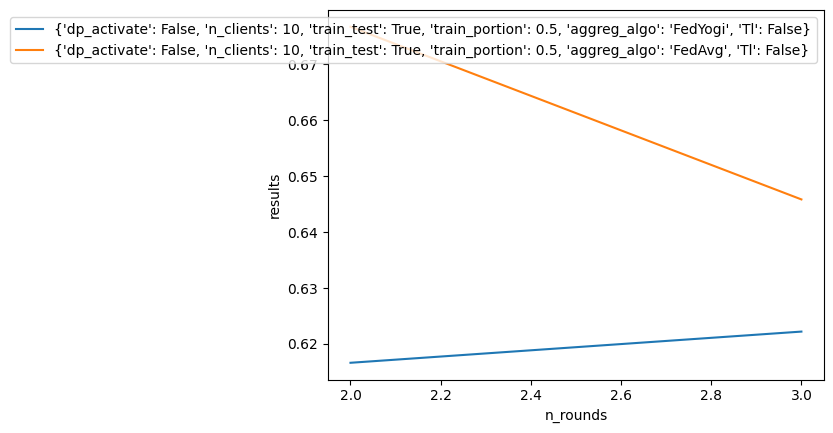

## Plot the results 

### 1. Differential Privacy
